# Exercise 14

## Predict rating using LSTM


In [1]:
import pandas as pd

In [2]:
dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)

In [3]:
plots = dataTraining['plot']
y = (dataTraining['rating'] >= dataTraining['rating'].mean()).astype(int)

In [4]:
plots

3107    most is the story of a single father who takes...
900     a serial killer decides to teach the secrets o...
6724    in sweden ,  a female blackmailer with a disfi...
4704    in a friday afternoon in new york ,  the presi...
2582    in los angeles ,  the editor of a publishing h...
                              ...                        
8417    " our marriage ,  their wedding .  "  it ' s l...
1592    the wandering barbarian ,  conan ,  alongside ...
1723    like a tale spun by scheherazade ,  kismet fol...
7605    mrs .  brisby ,  a widowed mouse ,  lives in a...
215     tinker bell journey far north of never land to...
Name: plot, Length: 7895, dtype: object

In [5]:
y

3107    1
900     0
6724    1
4704    1
2582    1
       ..
8417    0
1592    0
1723    0
7605    1
215     1
Name: rating, Length: 7895, dtype: int64

# Exercise 14.1

- Remove stopwords 
- Lowercase
- split the text in words 
- pad_sequences

#### **convertimos los textos a minusculas y removemos puntuacion**

In [6]:
import string
import re
def clean_text(article):
    clean1 = re.sub(r'['+string.punctuation + '’—”'+']', "", article.lower())
    return re.sub(r'\W+', ' ', clean1)

In [7]:
dataTraining['tockenized'] = dataTraining['plot'].map(lambda x: clean_text(x))

#### **convertimos los textos a listas**

In [8]:
X = dataTraining['tockenized'].tolist()

#### **removemos las stopwords**

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords=set(stopwords.words('english'))

def remove_stopwords(data):
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            if word.lower() not in stopwords:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    return output_array
 
X = remove_stopwords(X)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
voc = set((' '.join(X)).split())
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

#### **dividimos los textos en palabras**

In [11]:
X = [x.split() for x in X]
len_ = pd.Series([len(x) for x in X])

In [12]:
len_.describe(percentiles=[0.975])

count    7895.000000
mean       68.637619
std        44.545394
min         0.000000
50%        60.000000
97.5%     179.650000
max       820.000000
dtype: float64

#### **podemos observar que el percentil 97.5 tiene una extensión de 180 palabras. Por tanto, usamos este valor apra max_len**

In [13]:
# Max len
max_doc_len = 180
X = [x[:max_doc_len] for x in X]
# Convert characters to int and pad
X = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X]

#### **continuamos con el pad sequence**

In [14]:
from keras.preprocessing import sequence
X_pad = sequence.pad_sequences(X, maxlen = max_doc_len)
X_pad

Using TensorFlow backend.


array([[    0,     0,     0, ..., 20860, 10777, 16206],
       [    0,     0,     0, ..., 30249, 23844, 15192],
       [    0,     0,     0, ..., 35667, 35147,  9401],
       ...,
       [    0,     0,     0, ..., 27042, 13102, 33784],
       [    0,     0,     0, ..., 25492, 18981, 25369],
       [    0,     0,     0, ...,  5709, 19690, 15260]], dtype=int32)

# Exercise 14.2

Create a LSTM neural network to predict the rating of a movie

Calculate the testing set accuracy

In [15]:
import keras
from keras import backend as K

In [16]:
!pip install livelossplot
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [17]:
from livelossplot import PlotLossesKeras
%matplotlib inline

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.33, random_state = 42)

In [26]:
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 128, input_length=max_doc_len))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 180, 128)          4935296   
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,984,769
Trainable params: 4,984,769
Non-trainable params: 0
_________________________________________________________________


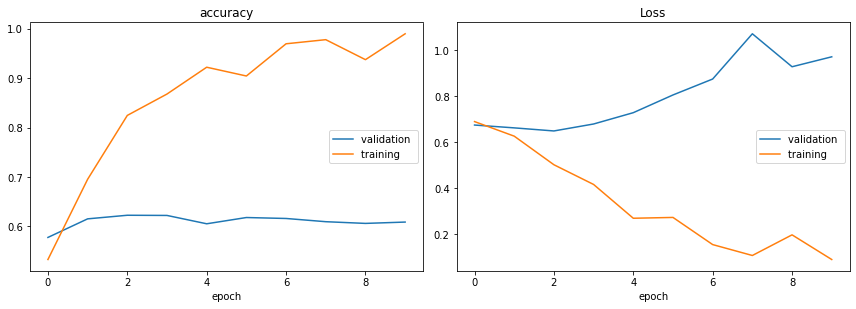

accuracy
	validation       	 (min:    0.578, max:    0.622, cur:    0.609)
	training         	 (min:    0.533, max:    0.990, cur:    0.990)
Loss
	validation       	 (min:    0.650, max:    1.072, cur:    0.972)
	training         	 (min:    0.090, max:    0.690, cur:    0.090)


In [27]:
model.fit(X_train, y_train, validation_data=[X_test, y_test], 
          batch_size = 1000, epochs = 10, verbose = 1,
          callbacks=[PlotLossesKeras()])

In [28]:
score, acc = model.evaluate(X_test, y_test, verbose = 1, batch_size = 1000)
print("Score: %.2f" % (score))
print("Validation Accuracy: %.2f" % (acc))

2606/2606 [==============================] - 0s 75us/step
Score: 0.97
Validation Accuracy: 0.61


#### **podemos observar que la red entrenada tiene un accuracy de 0.61**